<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [67]:
# Set your student number
student_number = 400101356
Name = 'Ali'
Last_Name = 'Soltani'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

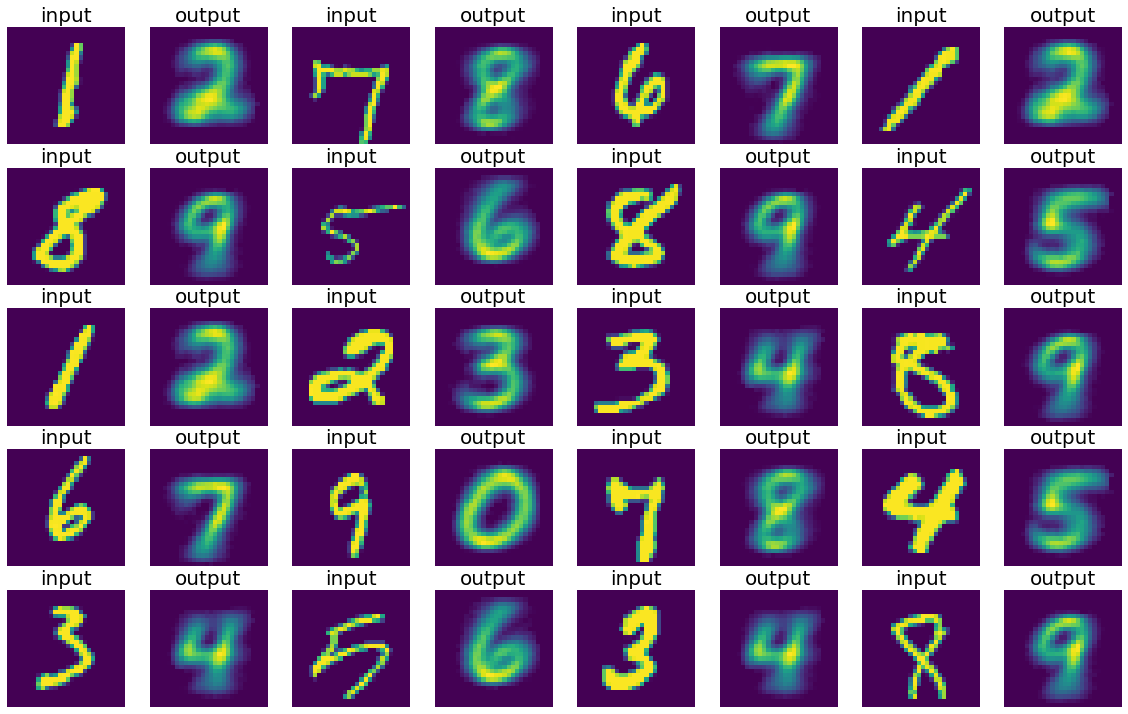

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [68]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [69]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [70]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).unsqueeze(1).float()
        self.Y = torch.from_numpy(Y).unsqueeze(1).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [71]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.train()
    cumulative_loss = 0.0
    cumulative_mae = 0.0

    for X_batch, Y_batch, _ in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = nn.MSELoss()(outputs, Y_batch)  # Loss calculation
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step
        cumulative_loss += loss.item()  # Sum up the losses
        cumulative_mae += nn.L1Loss()(outputs, Y_batch).item()  # Sum up the MAE

    epoch_loss = cumulative_loss / len(dataloader)  # Average loss
    avg_mae = cumulative_mae / len(dataloader)  # Average MAE
    accuracy = 1 - avg_mae  # Accuracy estimation
    return epoch_loss, accuracy

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.eval()
    cumulative_loss = 0.0
    cumulative_mae = 0.0

    with torch.no_grad():  # No gradient computation
        for X_batch, Y_batch, _ in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            predicted = model(X_batch)  # Forward pass
            loss = nn.MSELoss()(predicted, Y_batch)  # Loss calculation
            cumulative_loss += loss.item()  # Sum up the losses
            cumulative_mae += nn.L1Loss()(predicted, Y_batch).item()  # Sum up the MAE

    epoch_loss = cumulative_loss / len(dataloader)  # Average loss
    avg_mae = cumulative_mae / len(dataloader)  # Average MAE
    accuracy = 1 - avg_mae  # Accuracy estimation
    return epoch_loss, accuracy


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [73]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
import torch.optim as optim 
ae = AutoEncoder().to(device=device)
optimizer = optim.Adam(ae.parameters(), lr=0.001)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [74]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

def train_and_validate(model, train_loader, val_loader, optimizer, epochs=20, patience=3):
    best_loss = float('inf')
    best_epoch = 0
    best_model = None
    patience_count = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train_autoencoder(model, optimizer, train_loader)
        val_loss, val_accuracy = eval_autoencoder(model, val_loader)

        if (val_loss < best_loss):
            best_loss = val_loss
            best_epoch = epoch
            best_model = model.state_dict()
            patience_count = 0
        else:
            patience_count += 1

        print(f"Epoch {epoch}:\nTrain Loss: {train_loss:.5f}\nTrain Accuracy: {train_accuracy:.4f}\nValidation Loss: {val_loss:.5f}\nValidation Accuracy: {val_accuracy:.4f}\n")

        if (patience_count >= patience):
            print(f"Early Stopping at Epoch {epoch}; Validation Loss Didn't Decrease for {patience} Epochs")
            break

    print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_loss:.5f}")
    return best_model

best_model_state = train_and_validate(ae, train_dataloader, val_dataloader, optimizer, epochs=20, patience = 3)


Epoch 1:
Train Loss: 0.10090
Train Accuracy: 0.8016
Validation Loss: 0.06784
Validation Accuracy: 0.8506

Epoch 2:
Train Loss: 0.06763
Train Accuracy: 0.8496
Validation Loss: 0.06726
Validation Accuracy: 0.8499

Epoch 3:
Train Loss: 0.06691
Train Accuracy: 0.8515
Validation Loss: 0.06616
Validation Accuracy: 0.8565

Epoch 4:
Train Loss: 0.06473
Train Accuracy: 0.8567
Validation Loss: 0.06416
Validation Accuracy: 0.8541

Epoch 5:
Train Loss: 0.06327
Train Accuracy: 0.8587
Validation Loss: 0.06291
Validation Accuracy: 0.8613

Epoch 6:
Train Loss: 0.06131
Train Accuracy: 0.8625
Validation Loss: 0.05994
Validation Accuracy: 0.8641

Epoch 7:
Train Loss: 0.05854
Train Accuracy: 0.8676
Validation Loss: 0.05761
Validation Accuracy: 0.8688

Epoch 8:
Train Loss: 0.05684
Train Accuracy: 0.8705
Validation Loss: 0.05630
Validation Accuracy: 0.8701

Epoch 9:
Train Loss: 0.05593
Train Accuracy: 0.8722
Validation Loss: 0.05568
Validation Accuracy: 0.8709

Epoch 10:
Train Loss: 0.05548
Train Accuracy: 

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [75]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
ae.load_state_dict(best_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

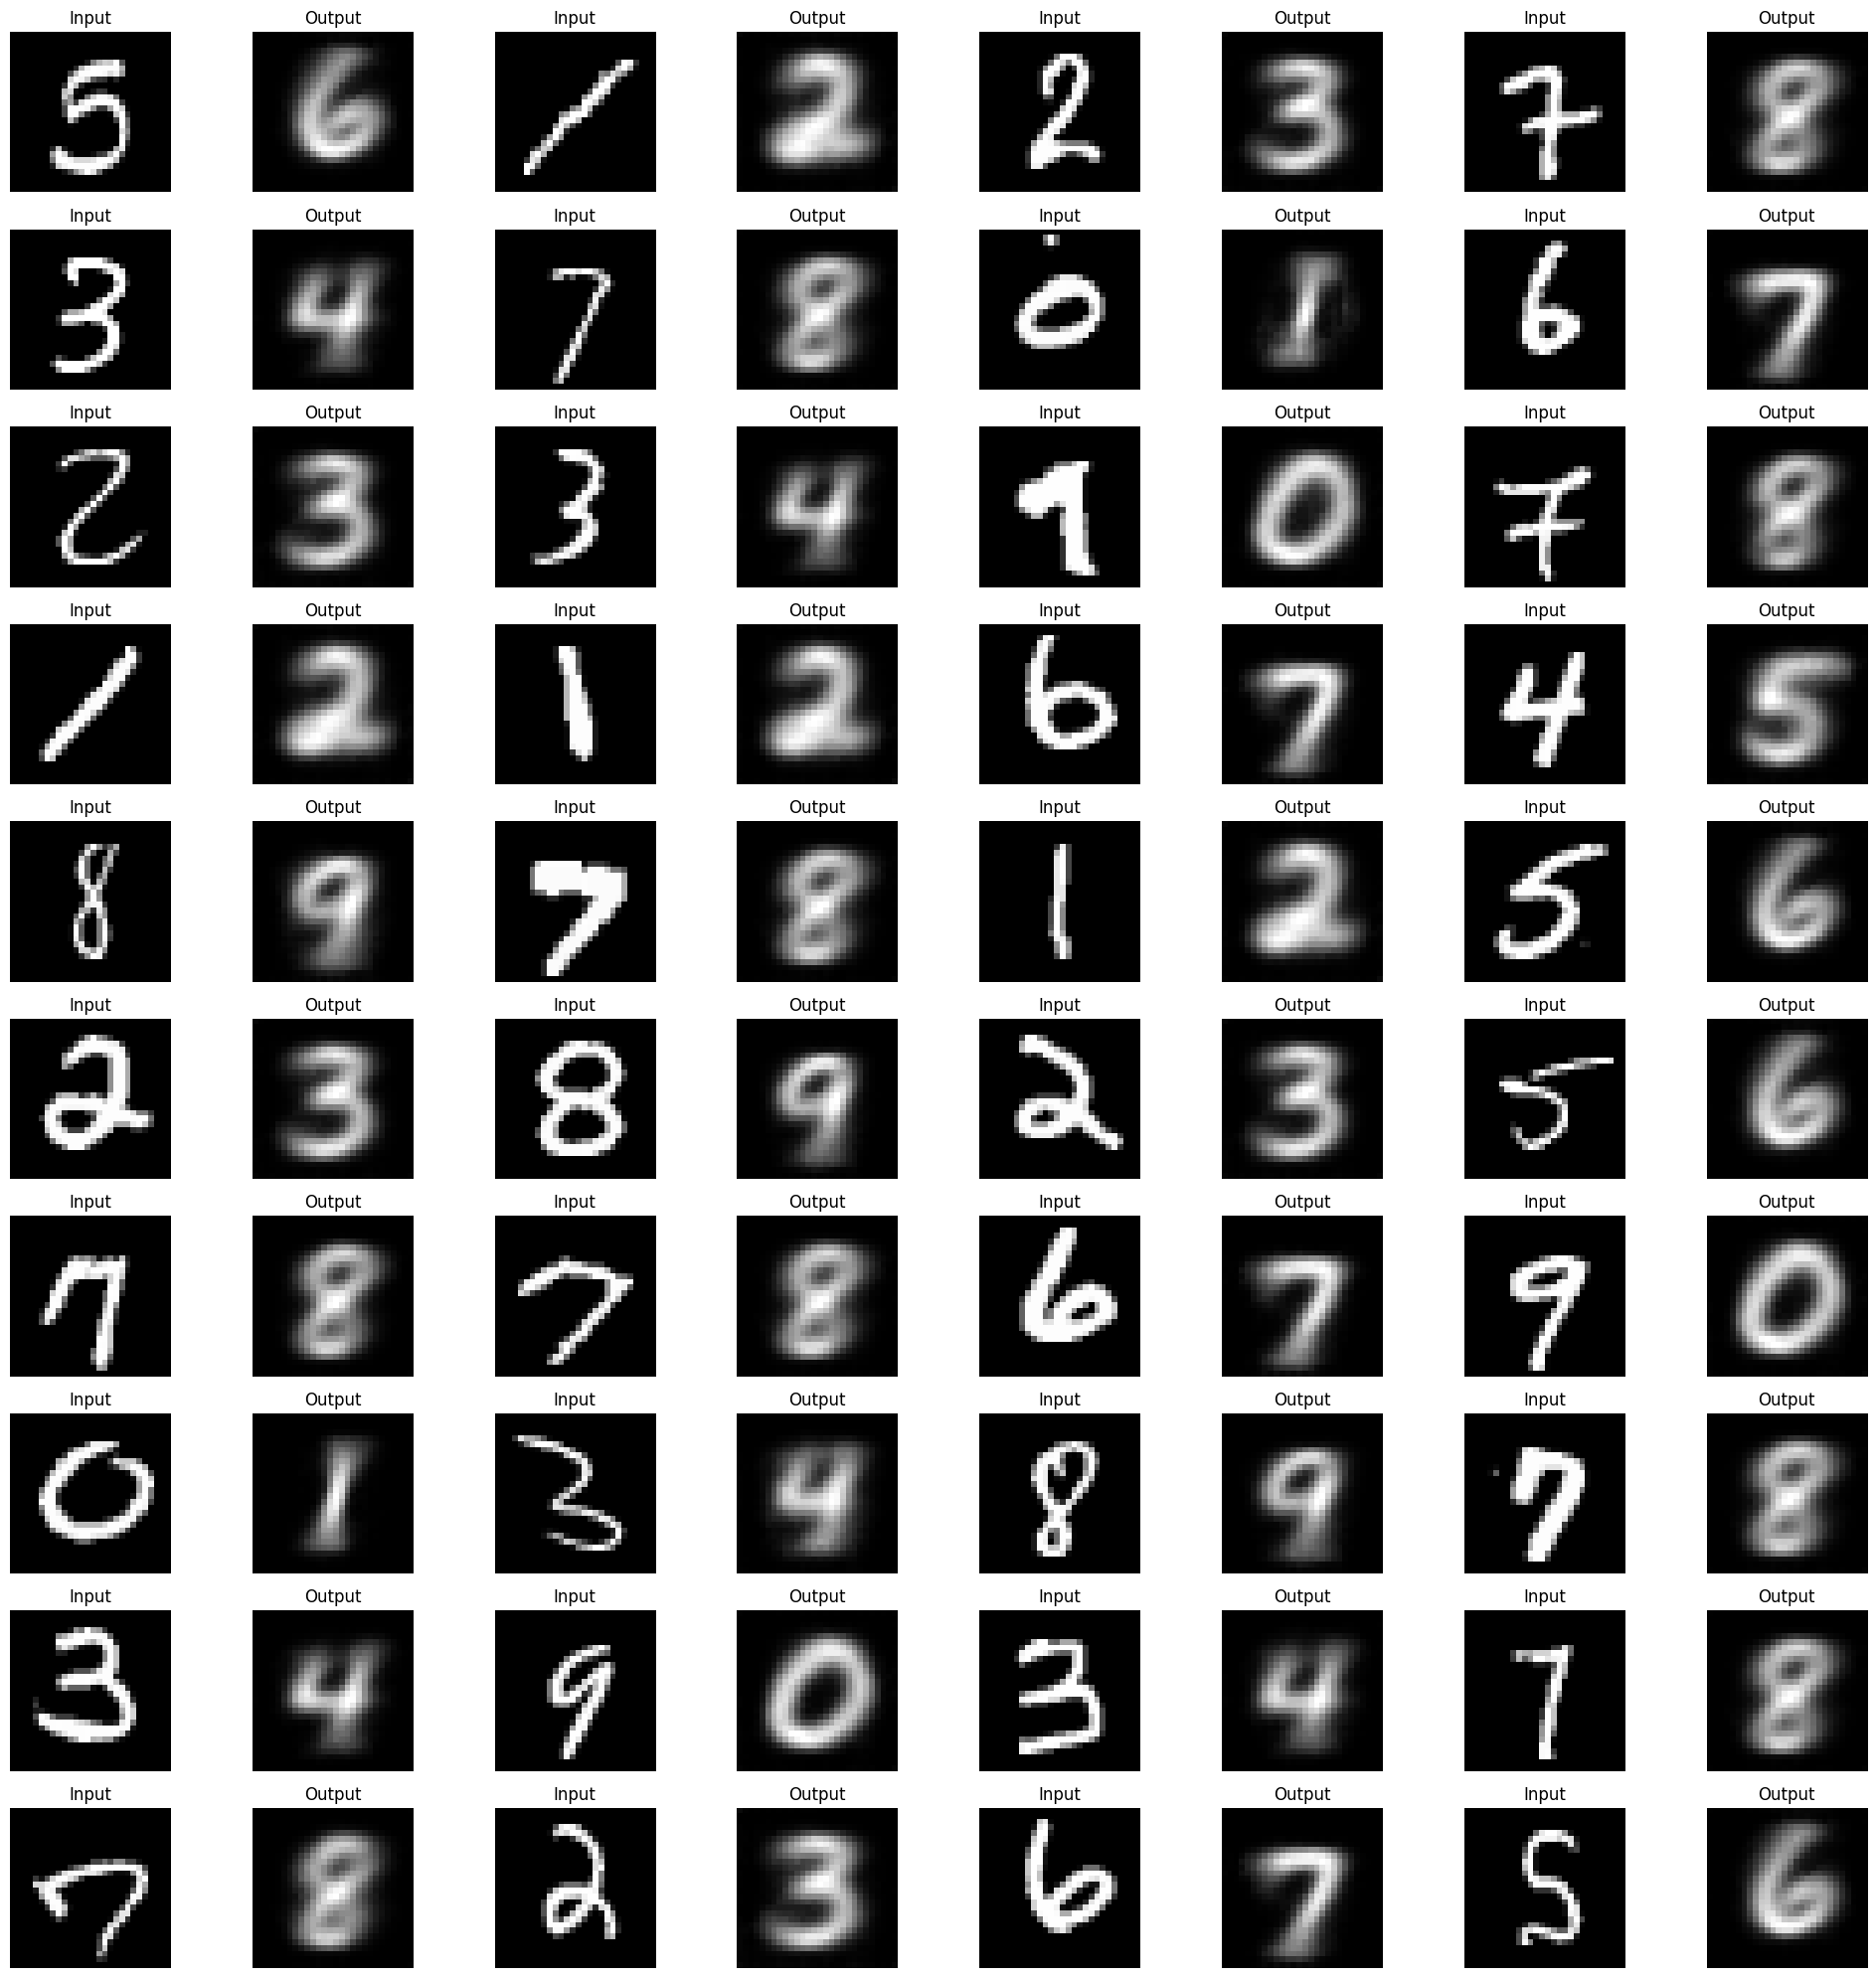

In [95]:
#### VISUALIZE YOUR MODEL ####
import matplotlib.pyplot as plt

# Create DataLoader
test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=40,
    shuffle=True
)

# Retrieve a batch of test images
images, _, _ = next(iter(test_dataloader))
images = images.to(device)

# Get model outputs
ae.eval()
with torch.no_grad():  # No need to compute gradients
    outputs = ae(images).cpu()

# Move images back to CPU for visualization
images = images.cpu()

# Plot original and reconstructed images
_, axes = plt.subplots(10, 8, figsize=(20, 20))

for i in range(0, 40):
    axes[i // 4, 2 * (i % 4)].imshow(images[i].squeeze(), cmap='gray')
    axes[i // 4, 2 * (i % 4)].set_title('Input')
    axes[i // 4, 2 * (i % 4)].axis('off')
    axes[i // 4, 2 * (i % 4) + 1].imshow(outputs[i].squeeze(), cmap='gray')
    axes[i // 4, 2 * (i % 4) + 1].set_title('Output')
    axes[i // 4, 2 * (i % 4) + 1].axis('off')

plt.tight_layout()
plt.show()
